# Set up Environment

In [1]:
import scanpy as sc
import pandas as pd
import seaborn as sns
import copy
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import logging, sys
logging.disable(sys.maxsize)

In [2]:
combined = sc.read('/scratch/qc_filtered_combined_samples.h5ad')

# Select the Cells of Interest

#### Before any further analysis we will exclude the cells that are neither CD8+ nor TCR+. First select the TCR and CD8 genes. #### Even though drop-out events are possible, it is extremely unlikely if drop-outs happen simultaneous for all 160 genes of a single cell. So by doing this we are almost 100% confident that we are subsetting all the T-cells, especially all of the CD8 T-cells

In [3]:
selected_genes = combined.var_names.str.startswith(("TRAV","TRAJ","TRBV","TRBD","TRBJ","CD8A","CD8B"))
CD8_related_genes = set(combined[:,selected_genes].var_names)

In [4]:
print("There are {} genes selected".format(len(CD8_related_genes)))

There are 168 genes selected


In [5]:
kept_cells = combined[:,'CD8A'].X>0
for gene in set(CD8_related_genes):
    kept_cells = kept_cells + (combined[:,gene].X>0)

In [6]:
# Now abusing the notation ( we again call it "combined" so that we don't have to change the rest of the code), we subset 
# the cells using the genes 
combined = combined[kept_cells,:]

In [7]:
print('The number of CD8+ T cells in each sample')
for sample in set(combined.obs['sample']):
    print("{}: {}".format(sample,str(sum(combined[combined[:,'CD8A'].X>0].obs['sample']==sample))))

The number of CD8+ T cells in each sample
309_Pri: 424
330_Met: 5046
290_Pri: 1997
296_Pri_CD8neg: 4
330_Pri: 1538
290_LN2: 3030
307_sLN: 610
310: 114
295: 5109
309_sLN: 176
296_Pri_CD8pos: 1307
289_Pri: 37
338_LN2: 2128
314: 4095
315: 5281
304_Pri: 343
313: 3974
316: 3665
291_Pri: 794
307_Pri: 177
325_Pri: 739
305_1_Pri: 1529
338_Pri: 2032
305_2_Pri: 1054
325_sLN: 3670


# Select Important and Highly Variable Genes

#### Find highly variable features/genes that will also provide a good separation of the cell types and cell clusters.

Highly variable genes: 500


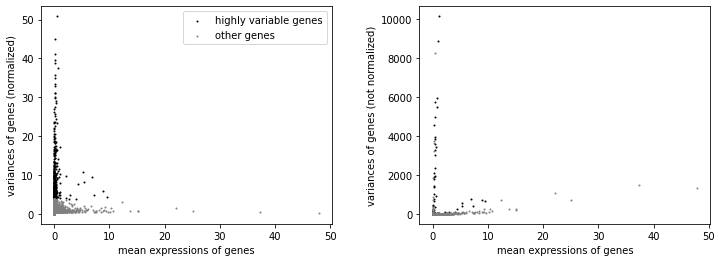

In [8]:
# compute variable genes
sc.pp.highly_variable_genes(combined, flavor='seurat_v3',n_top_genes=500)
print("Highly variable genes: {}".format(sum(combined.var.highly_variable)))

# plot variable genes
sc.pl.highly_variable_genes(combined)

CD62L,L-selectin: 'SELL', CD45: 'PTPRC', CD95:'FAS'

In [9]:
important_marker_genes = ['CD8A','CD8B','PTPRC','TBX21','CCR5','CXCR3','IL7','SELL','GATA3','CCR6','IL4','GZMB',
                          'PRF1','IL2RB','IL2RA','FOXP3','CD28','IL10','CD44','EOMES','IL17A','IL17B','IL17C','IL10','CD69'
                          'CD27','FAS','KLRG1','CCR7','GZMA','GZMH','GZMK','GZMM','GNYL','ENTPD1','TCF7','ITGAE','CTSW', 
                          'IFNG','CD161','TNFRSF4','TNFRSF18','NKG7','B3GAT1']

In [10]:
important_nonmarker_genes = ['CD4','CD68','CD163','MS4A2','CD14','CD16','XCL2','COL1A2','MMP2','ACTA2','CD79A',
                             'LAMP3','TPSAB1','PECAM1']

PD-1: 'PDCD1', TIM3:'HAVCR2'

In [11]:
exhaustion_markers = ['CXCL13','CTLA4','PDCD1','HAVCR2','TIGIT','BTLA','CD244','CD160','ICOS','LAG3']

CD137:'TNFRSF9', KI67:'MKI67'

In [12]:
proliferation_markers = ['TOP2A','MKI67','TNFRSF9'] 

In [13]:
#HLA_class1_genes = combined.var_names.str.startswith(('HLA-A','HLA-B','HLA-C','HLA-E','HLA-F','HLA-G'))
#HLA_class2_genes = combined.var_names.str.startswith(('HLA-DM','HLA-DQ','HLA-DO','HLA-DP','HLA-DR'))
#HLA_class1_genes = list(combined[:,HLA_class1_genes].var_names)
#HLA_class2_genes = list(combined[:,HLA_class2_genes].var_names)

In [14]:
important_genes = important_marker_genes + important_nonmarker_genes+exhaustion_markers+proliferation_markers

In [15]:
# filter out the TCR genes in case their idiosyncrasy skews the clustering 
selected = list(combined.var_names.str.startswith(("TRA","TRB","HLA")))
TCR_genes = set(combined[:,selected].var_names)
for gene in TCR_genes:
    combined.var['highly_variable'][gene] = False

In [16]:
# restore the genes in case they are filtered out, all genes (including top 200 and the important markers 
# are stored as highly variable)
for gene in important_genes:
    combined.var['highly_variable'][gene] = True

In [17]:
# combined.raw stores a scopy of the data at current stage
# we do this since we will trim genes and only use the top few hundreds for clustering, yet we want to retain all genes for
# differential expression purposes

In [18]:
combined.raw = combined
combined = combined[:, combined.var['highly_variable']]

## Regress out cell cycles

In [19]:
# Extract cell cycle genes 
cell_cycle_genes = [x.strip() for x in open('/work/cell_cycle_genes.txt')]

s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in combined.var_names]

In [20]:
# compute gene scores for cell cycle genes which we will regress out
sc.tl.score_genes_cell_cycle(combined, s_genes=s_genes, g2m_genes=g2m_genes)

# regress out effects of total counts per cell and scale genes to have unit variance
sc.pp.regress_out(combined, ['total_counts', 'S_score', 'G2M_score'])

## PCA

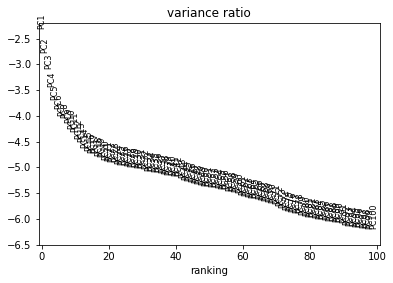

In [21]:
sc.pp.scale(combined, zero_center=False, max_value=10)

sc.tl.pca(combined, svd_solver='arpack',n_comps=100,use_highly_variable=True)
sc.pl.pca_variance_ratio(combined, log=True, n_pcs = 100)

In [22]:
save_file = '/scratch/PCA_decomposed_combined_samples.h5ad'
combined.write_h5ad(save_file)

# Dimension Reduction by Manifold Embedding

In [23]:
# bbknn is a batch correction algorithm that also computes neighbor graph
sc.external.pp.bbknn(combined, batch_key='bat', n_pcs=35)

In [24]:
# project to a 2-dimensional subspace, save to a new object so that the umap with 2D is not overwritten.
batch_corrected_umap = sc.tl.umap(combined, n_components=2, copy=True,min_dist=0.05)

In [25]:
# Leiden clustering
sc.tl.leiden(batch_corrected_umap)
# find marker genes
sc.tl.rank_genes_groups(batch_corrected_umap, groupby='leiden',method='wilcoxon')

In [26]:
# save file 
save_file = '/scratch/batch_corrected_umap.h5ad'
batch_corrected_umap.write_h5ad(save_file)